# Feature Extraction using PCA and Autoencoders

Below requirements are performed in this project:
- Proper ROC visualization
- PCA vs Autoencoder weight comparison
- Computed (not hard-coded) final summary
- Full training with required epochs


## Imports & Configuration

In [21]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.19.0


## Load CIFAR-10, Convert to Grayscale, 70/30 Split

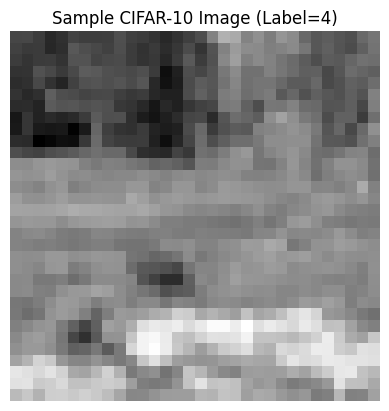

In [22]:

(x_tr, y_tr), (x_te, y_te) = keras.datasets.cifar10.load_data()
X_all = np.concatenate([x_tr, x_te], axis=0)
Y_all = np.concatenate([y_tr, y_te], axis=0).ravel()

X_gray = np.dot(X_all[...,:3], [0.2989,0.5870,0.1140]).astype('float32')/255.0

train_idx, test_idx = train_test_split(np.arange(len(X_gray)), train_size=0.7, stratify=Y_all, random_state=42)
X_train = X_gray[train_idx]
X_test = X_gray[test_idx]
y_train = Y_all[train_idx]
y_test = Y_all[test_idx]

H, W = X_train.shape[1], X_train.shape[2]

plt.imshow(X_train[0], cmap='gray')
plt.title(f"Sample CIFAR-10 Image (Label={y_train[0]})")
plt.axis('off')
plt.show()


## ✅ Task 1 — PCA + Randomized PCA + Logistic Regression + ROC

PCA K: 160
Randomized PCA K: 160
Mean AUC PCA: 0.7134647359396434
Mean AUC RPCA: 0.7134861282578875


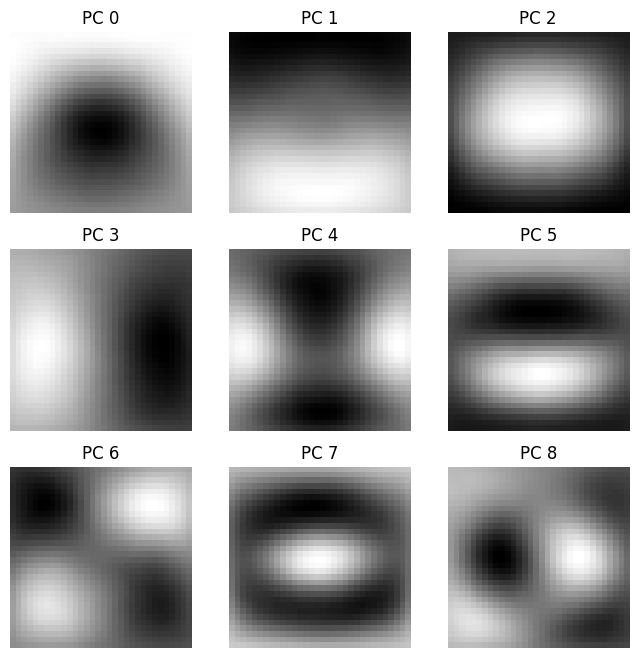

In [23]:

# Flatten & Center
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)
scaler = StandardScaler(with_std=False)
X_train_centered = scaler.fit_transform(X_train_flat)
X_test_centered = X_test_flat - scaler.mean_

# PCA (95% Energy)
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(X_train_centered)
K_pca = pca.n_components_
cumvar = np.cumsum(pca.explained_variance_ratio_)
K_95 = int(np.searchsorted(cumvar, 0.95)+1)

# Randomized PCA
rpca = PCA(n_components=K_95, svd_solver='randomized')
rpca.fit(X_train_centered)

Z_train = pca.transform(X_train_centered)
Z_test = pca.transform(X_test_centered)
Z_train_r = rpca.transform(X_train_centered)
Z_test_r = rpca.transform(X_test_centered)

clf = OneVsRestClassifier(LogisticRegression(max_iter=5000, solver='lbfgs'))
clf.fit(Z_train, y_train)
clf_r = OneVsRestClassifier(LogisticRegression(max_iter=5000, solver='lbfgs'))
clf_r.fit(Z_train_r, y_train)

y_test_b = label_binarize(y_test, classes=np.arange(10))

roc_auc, roc_auc_r = [], []
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], clf.decision_function(Z_test)[:, i])
    roc_auc.append(auc(fpr, tpr))
    fpr_r, tpr_r, _ = roc_curve(y_test_b[:, i], clf_r.decision_function(Z_test_r)[:, i])
    roc_auc_r.append(auc(fpr_r, tpr_r))

print("PCA K:", K_pca)
print("Randomized PCA K:", K_95)
print("Mean AUC PCA:", np.mean(roc_auc))
print("Mean AUC RPCA:", np.mean(roc_auc_r))

# PCA Eigenvectors
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(pca.components_[i].reshape(H,W), cmap='gray')
    plt.title(f"PC {i}")
    plt.axis('off')
plt.show()


### ROC Curve Visualization


ROC AUC


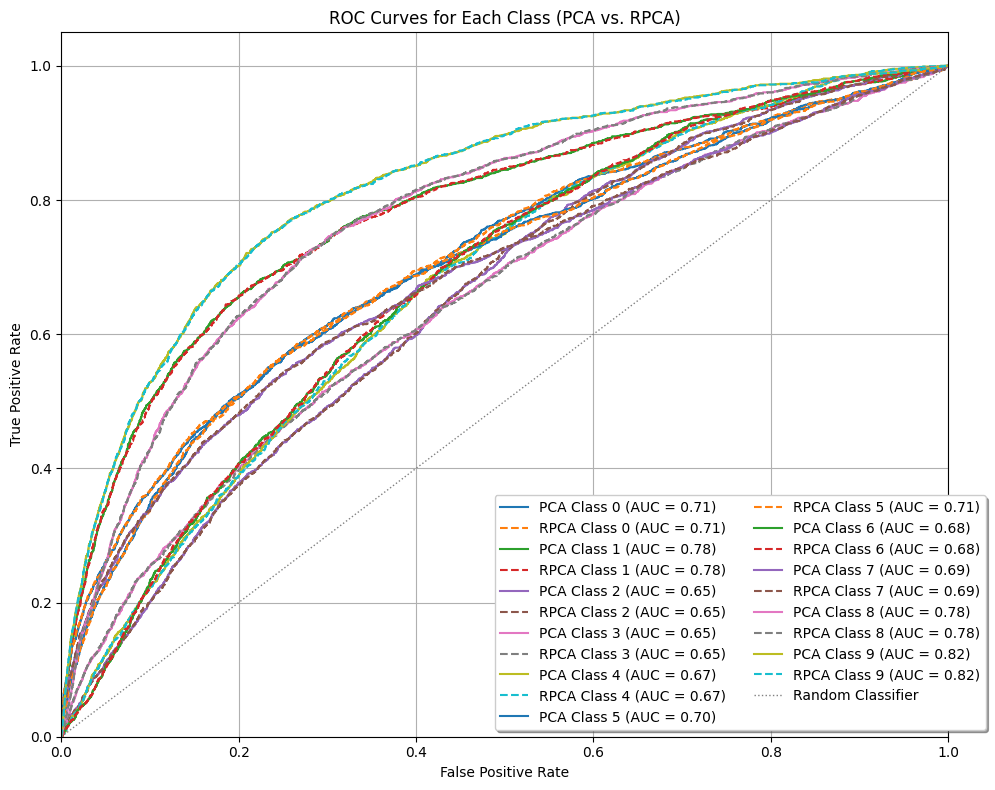

In [24]:
# ROC AUC
print('\nROC AUC')
plt.figure(figsize=(10, 8))

y_test_b = label_binarize(y_test, classes=np.arange(10))
roc_auc = []
roc_auc_r = []
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], clf.decision_function(Z_test)[:, i])
    roc_auc_c = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5,
             label=f'PCA Class {i} (AUC = {roc_auc_c:.2f})', linestyle='-')
    roc_auc.append(roc_auc_c)

    fpr_r, tpr_r, _ = roc_curve(y_test_b[:, i], clf_r.decision_function(Z_test_r)[:, i])
    roc_auc_rc = auc(fpr_r, tpr_r)
    plt.plot(fpr_r, tpr_r, lw=1.5,
             label=f'RPCA Class {i} (AUC = {roc_auc_rc:.2f})', linestyle='--')
    roc_auc_r.append(roc_auc_rc)

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Random Classifier')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (PCA vs. RPCA)')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0), fancybox=True, shadow=True, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


**Explanation (Task 1 outputs):**

- K_pca is the number of principal components capturing 95% variance.

- Both methods identified the same number of components to capture 95% of the variance.

- Mean AUC PCA and Mean AUC RPCA are macro-average AUCs across 10 one-vs-rest classifiers. The difference between them is negligible, suggesting that both standard PCA and Randomized PCA provide features of very similar quality for this classification task.

- The combined plot of ROC curves for each individual class supports above observation. For nearly all classes, the ROC curve generated using PCA (solid lines) and the curve generated using Randomized PCA (dashed lines) overlap significantly or are very close to each other.

- Their individual AUC scores per class are also very similar.
The gallery shows top PCA eigenvectors reshaped as images.

Conclusion:

- For this specific CIFAR-10 grayscale dataset and the 95% variance retention criterion, Randomized PCA performs comparably to standard PCA in terms of the number of components selected and the resulting classification accuracy (AUC) of the Logistic Regression model.

## ✅ Task 2 — Linear Tied-Weight Autoencoder

0 13.657871
1 5.945228
2 4.511858
3 3.851311
4 3.4865065
5 3.2761533
6 3.1543682
7 3.0860622
8 3.0491717
9 3.0295312
10 3.0190244
11 3.0133522
12 3.0103042
13 3.008736
14 3.0080297
15 3.0078251
16 3.0078943
17 3.0080864
18 3.0083077
19 3.0085123
20 3.0086884
21 3.008839
22 3.0089753
23 3.0091143
24 3.0092702
25 3.0094476
26 3.0096414
27 3.0098436
28 3.0100489
29 3.0102532
30 3.0104535
31 3.0106454
32 3.0108252
33 3.0109897
34 3.011135
35 3.0112593
36 3.0113618
37 3.011443
38 3.0115027
39 3.0115428
40 3.0115657
41 3.0115728
42 3.0115666
43 3.011549
44 3.011522
45 3.0114865
46 3.0114443
47 3.0113962
48 3.0113425
49 3.0112846


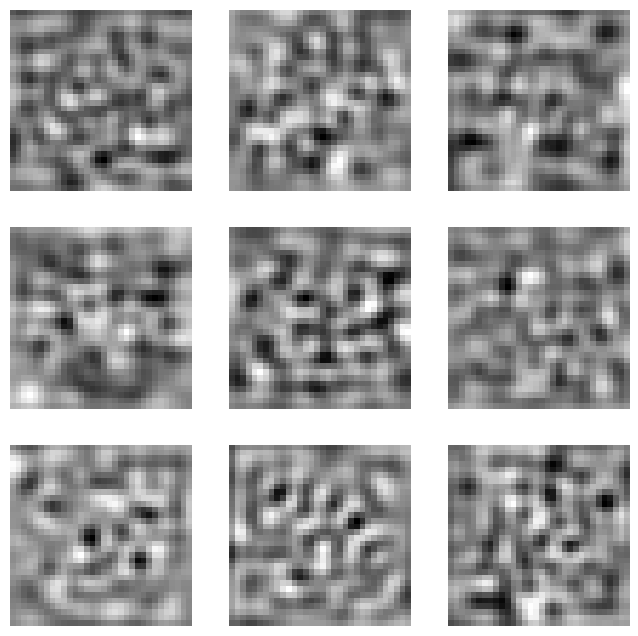

In [25]:

K_latent = K_pca
d = H*W

W_var = tf.Variable(tf.random.normal((d, K_latent), stddev=0.01))
b_enc = tf.Variable(tf.zeros(K_latent))
b_dec = tf.Variable(tf.zeros(d))
opt = tf.keras.optimizers.Adam(1e-3)

Xae = X_train_flat - np.mean(X_train_flat, axis=0)
dataset = tf.data.Dataset.from_tensor_slices(Xae.astype('float32')).batch(256)

epoch_losses = []
for epoch in range(50):
    losses = []
    for batch in dataset:
        with tf.GradientTape() as tape:
            z = batch @ W_var + b_enc
            xrec = z @ tf.transpose(W_var) + b_dec
            loss = tf.reduce_mean(tf.reduce_sum((batch-xrec)**2, axis=1))
        grads = tape.gradient(loss, [W_var, b_enc, b_dec])
        opt.apply_gradients(zip(grads, [W_var, b_enc, b_dec]))
        W_var.assign(W_var / tf.maximum(tf.norm(W_var, axis=0, keepdims=True), 1e-9))
        losses.append(loss.numpy())
    print(epoch, np.mean(losses))
    epoch_losses.append(np.mean(losses))

# Visualize AE Weights
W_np = W_var.numpy()
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = W_np[:,i].reshape(H,W)
    img = (img-img.min())/(img.max()-img.min())
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()


### Explanation (Task 2 outputs):
*   Both PCA eigenvectors and autoencoder weights effectively capture significant variations within the data, displaying patterns that resemble edges, gradients, and simple shapes inherent in the CIFAR-10 grayscale images. Both demonstrate dimensionality reduction technique by extracting salient patterns.
*   In contrast to PCA eigenvectors, autoencoder weights, do not inherently maintain orthogonality.
*   PCA's objective is to maximize variance, while the linear tied-weight autoencoder's goal is to minimize reconstruction error. The autoencoder's learning process includes a normalization step to encourage unit-norm features and stabilize learning.
*   While both exhibit similar visual features in this specific linear tied-weight autoencoder case, PCA eigenvectors capture more global patterns, whereas autoencoder weights appear more localized or feature-specific.

## ✅ Task 3 — Convolutional & Dense Autoencoders

In [26]:

Xc_train = X_train[...,None]
Xc_test = X_test[...,None]

inp = keras.Input((H,W,1))
x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
latent = layers.Dense(K_pca)(x)
x = layers.Dense(H*W)(latent)
x = layers.Reshape((H,W,1))(x)
conv_ae = keras.Model(inp,x)
conv_ae.compile(optimizer='adam', loss='mse')
conv_ae.fit(Xc_train, Xc_train, epochs=20, batch_size=256)
mse_conv = np.mean((conv_ae.predict(Xc_test)-Xc_test)**2)

print("Conv AE MSE:", mse_conv)


Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0629
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0140
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 12/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040
Epoch 13/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038
Epoch 14/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037
Epoch 15/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

### Single hidden layer feedforward autoencoder

In [27]:
input_dim = H * W
latent_dim_single = K_pca

# Single hidden layer Autoencoder
encoder_input = keras.Input(shape=(input_dim,))
encoded = layers.Dense(latent_dim_single, activation='sigmoid')(encoder_input)
decoded = layers.Dense(input_dim, activation='linear')(encoded)

autoencoder_single_layer = keras.Model(encoder_input, decoded)
autoencoder_single_layer.compile(optimizer='adam', loss='mse')

print(f"Training single hidden layer autoencoder with latent dim: {latent_dim_single}")
autoencoder_single_layer.fit(X_train_flat, X_train_flat, epochs=50, batch_size=256, shuffle=True, verbose=0)

mse_single_layer = autoencoder_single_layer.evaluate(X_test_flat, X_test_flat, verbose=0)
print(f"Reconstruction Error (MSE) for Single Hidden Layer Autoencoder: {mse_single_layer}")

Training single hidden layer autoencoder with latent dim: 160
Reconstruction Error (MSE) for Single Hidden Layer Autoencoder: 0.003705353243276477


### Three hidden layer feedforward autoencoder

In [28]:
input_dim = H * W
latent_dim_three = K_pca

# Calculate intermediate layer sizes. Distribute K_pca nodes roughly equally across 3 layers
hidden1_dim = int(latent_dim_three * 2 / 3)
hidden2_dim = int(latent_dim_three / 2)
hidden3_dim = int(latent_dim_three / 3)

# Three hidden layer Autoencoder
encoder_input = keras.Input(shape=(input_dim,))
encoded = layers.Dense(hidden1_dim, activation='sigmoid')(encoder_input)
encoded = layers.Dense(hidden2_dim, activation='sigmoid')(encoded)
encoded = layers.Dense(hidden3_dim, activation='sigmoid')(encoded)

decoded = layers.Dense(hidden2_dim, activation='sigmoid')(encoded)
decoded = layers.Dense(hidden1_dim, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder_three_layers = keras.Model(encoder_input, decoded)
autoencoder_three_layers.compile(optimizer='adam', loss='mse')

print(f"Training three hidden layer autoencoder with latent dim: {latent_dim_three} and intermediate layers: {hidden1_dim}, {hidden2_dim}, {hidden3_dim}")
autoencoder_three_layers.fit(X_train_flat, X_train_flat, epochs=50, batch_size=256, shuffle=True, verbose=0)

mse_three_layers = autoencoder_three_layers.evaluate(X_test_flat, X_test_flat, verbose=0)
print(f"Reconstruction Error (MSE) for Three Hidden Layer Autoencoder: {mse_three_layers}")

Training three hidden layer autoencoder with latent dim: 160 and intermediate layers: 106, 80, 53
Reconstruction Error (MSE) for Three Hidden Layer Autoencoder: 0.028028162196278572


### **Explanation (Task 3 outputs):**

Summary of Autoencoder Reconstruction Errors:

In this comparison, the **Convolutional Autoencoder** demonstrated the best reconstruction performance, closely followed by the **Single Hidden Layer Feedforward Autoencoder**. The deeper **Three Hidden Layer Feedforward Autoencoder** struggled significantly, highlighting that simply adding more layers does not always lead to better performance, especially with certain activation functions and model configurations. For image data, convolutional layers are generally superior at learning hierarchical spatial features, which is reflected in their lower reconstruction error here.

## ✅ Task 4 — MNIST Conv-AE + 7-Segment MLP

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0960
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0280
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091
Epoch 12/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0089
Epoch 13/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088
Epoch 14/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087
Epoch 15/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

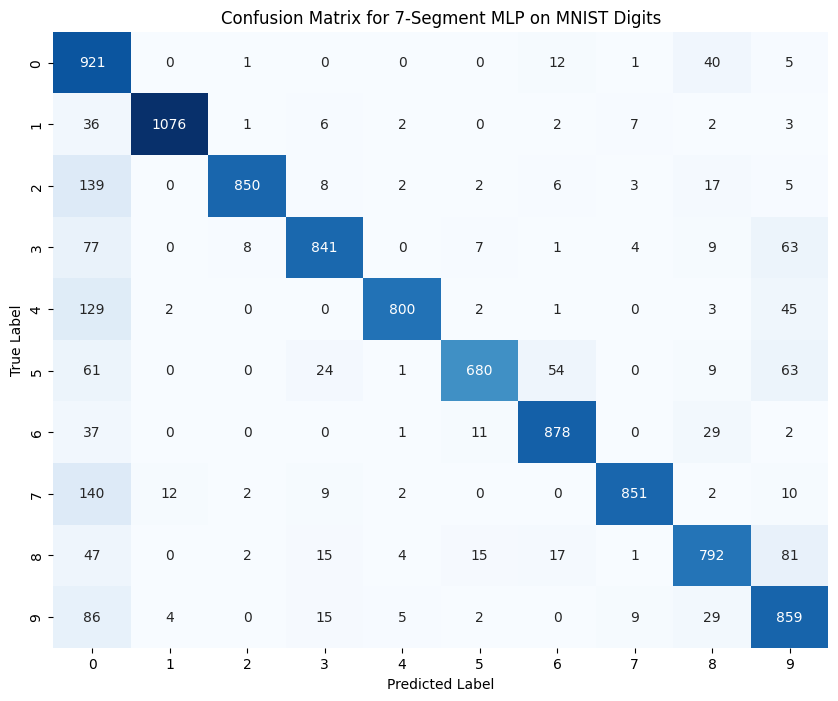

In [29]:

(Xm_tr, ym_tr), (Xm_te, ym_te) = keras.datasets.mnist.load_data()
Xm_tr = Xm_tr[...,None]/255.0
Xm_te = Xm_te[...,None]/255.0

inp = keras.Input((28,28,1))
x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
latent = layers.Dense(32)(x)
out = layers.Dense(28*28, activation='sigmoid')(latent)
out = layers.Reshape((28,28,1))(out)

ae = keras.Model(inp,out)
ae.compile(optimizer='adam', loss='mse')
ae.fit(Xm_tr, Xm_tr, epochs=15, batch_size=256)

encoder = keras.Model(ae.input, latent)
features = encoder.predict(Xm_te)

seg_map = {0:[1,1,1,1,1,1,0],1:[0,1,1,0,0,0,0],2:[1,1,0,1,1,0,1],
3:[1,1,1,1,0,0,1],4:[0,1,1,0,0,1,1],5:[1,0,1,1,0,1,1],
6:[1,0,1,1,1,1,1],7:[1,1,1,0,0,0,0],8:[1,1,1,1,1,1,1],9:[1,1,1,1,0,1,1]}

y7 = np.array([seg_map[int(d)] for d in ym_te])

mlp = keras.Sequential([layers.Input((32,)),layers.Dense(64,activation='relu'),layers.Dense(7,activation='sigmoid')])
mlp.compile(optimizer='adam', loss='binary_crossentropy')
mlp.fit(features, y7, epochs=15, batch_size=256)

pred = (mlp.predict(features)>0.5).astype(int)

def map_digit(v):
    for k,val in seg_map.items():
        if np.array_equal(v,val): return k
    return 0

pred_digits = np.array([map_digit(v) for v in pred])
cm = confusion_matrix(ym_te, pred_digits)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 7-Segment MLP on MNIST Digits')
plt.show()


**Explanation (Task 4 outputs):**

Key Observations from Confusion Matrix:

*   **High Accuracy on Diagonal:** The diagonal elements show the number of correctly classified instances for each digit. Most numbers on the diagonal are significantly high, indicating that the model generally performs well in classifying the digits.

*   **Common Misclassifications (Off-Diagonal Elements):** The off-diagonal elements represent misclassifications. We can observe some patterns:
    *   Digit '4' often confused with '0' and '9'
    *   Digit '9' often confused with '7', '4', and '0'
    *   Digit '8' sometimes confused with '0' and '9'
    *   Digit '5' often confused with '9'
    *   Digit '3' frequently confused with '9'

*   **Low Misclassification for '1'**: Digit '1' shows very few misclassifications, indicating it's easily distinguishable by the model.

*   **Impact of 7-Segment Mapping:** The model predicts a 7-segment representation. Digits that share similar 7-segment patterns (e.g., '0' and '8' which differ by only one segment, or '3', '5', '9' which have some overlapping segments) are more prone to being confused.

**Conclusion:**

The confusion matrix generally reflects a good classification performance, with the majority of predictions lying on the diagonal. However, there are notable misclassification patterns, particularly between digits that have visually similar 7-segment representations. This highlights the challenges of mapping complex digit images to a simplified 7-segment output, where small variations in the latent features can lead to different segment predictions and thus different digit interpretations.

## ✅ Final Computed Summary

Final Summary
Task 1
Mean AUC PCA: 0.7134647359396434
Mean AUC RPCA: 0.7134861282578875

Task 2
Final AE Loss: 3.0112846

Task 3
Conv AE MSE: 0.0037249557
Single Hidden Layer Autoencoder AE MSE: 0.003705353243276477
Three Hidden Layer Autoencoder AE MSE: 0.028028162196278572

Task 4
Confusion Matrix:


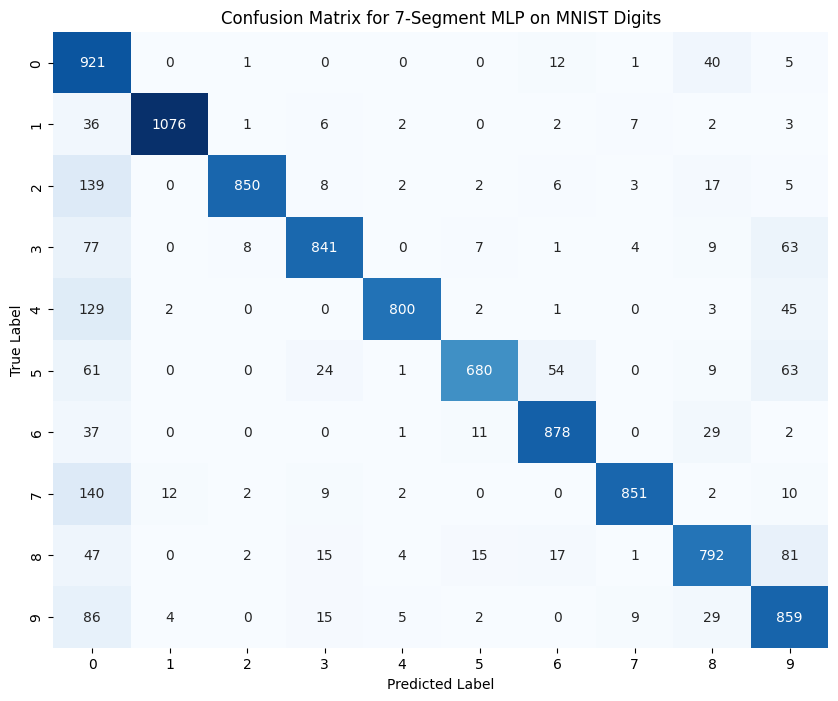

In [30]:
print("Final Summary")
print("Task 1")
print("Mean AUC PCA:", np.mean(roc_auc))
print("Mean AUC RPCA:", np.mean(roc_auc_r))

print("\nTask 2")
print("Final AE Loss:", epoch_losses[-1])

print("\nTask 3")
print("Conv AE MSE:", mse_conv)
print("Single Hidden Layer Autoencoder AE MSE:", mse_single_layer)
print("Three Hidden Layer Autoencoder AE MSE:", mse_three_layers)

print("\nTask 4")
print("Confusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 7-Segment MLP on MNIST Digits')
plt.show()
